# Exploring the National Parks of the United States
> "Wilderness is not a luxury but a necessity of the human spirit, and as vital to our lives as water and good bread. A civilization which destroys what little remains of the wild, the spare, the original, is cutting itself off from its origins and betraying the principle of civilization itself." <br>***Edward Abbey***, [Desert Solitare](https://www.goodreads.com/book/show/214614.Desert_Solitaire?ac=1&from_search=true&qid=3inpz3msB9&rank=1)<br><br>
"Like winds and sunsets, wild things were taken for granted until progress began to do away with them. Now, we face the question whether a still higher 'standard of living' is worth its cost in things natural, wild and free." <br>***Aldo Leopold***, [A Sand County Almanac](https://www.aldoleopold.org/about/aldo-leopold/sand-county-almanac/)

The United States and its territories are home to [sixty-three national parks](https://www.nationalgeographic.com/travel/article/beautiful-photos-of-all-us-national-parks?rid=1E8B7B3947E0EBECE8AF71C1C3BD31D6&cmpid=org=ngp::mc=crm-email::src=ngp::cmp=editorial::add=Compass_20220702) that are maintained by the Dept. of the Interior's [National Park Service (NPS)](https://irma.nps.gov/STATS/). The NPS was created through the [Organic Act of 1916](https://www.nps.gov/grba/learn/management/organic-act-of-1916.htm) "to conserve the scenery and the natural and historic objects and wildlife therein, and to provide for the enjoyment of the same in such manner and by such means as will leave them unimpaired for the enjoyment of future generations." The natural beauty, unique geological features, and diverse ecosystems of the parks attract visitors from all over the world. Visitation to the parks continues to increase each year, which has forced [some parks to require reservations](https://www.tripsavvy.com/national-parks-requiring-timed-entry-tickets-2022-5215453).<br><br>
**GOAL:** *(1)* Characterize reactional use of national parks in the United States; and *(2)* learn how to scrape and visualize data from a webpage.<br>
**DATA:** Publicly avaialable data on recreational use of the US national parks will be scrapped from the NPS website.<br>
**ANALYSIS:** Exploratory data analysis to gain insights into the dataset.<br>
**ETHICAL CONSIDERATIONS:** There are no apparent issues with privacy, transparency,
or accountability in terms of avaiable data. Whether access to the national parks is equitable across communities in the US should be considered further. The NPS has begun administering a [survey](https://www.nps.gov/subjects/socialscience/socioeconomic-monitoring-visitor-surveys.htm) to understand who accesses the parks, and whether access differs as a function of demographic and economic factors. I'd like to incorporate data from that survey into this notebook when it becomes publicly available.<br>
**ADDITIONAL CONSIDERATIONS:** None.

## Load libraries

In [1]:
import os
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Create parks data frame 
First step is to compile a data frame of the national parks in the United States. For practice, I will scrape this information from this [wiki page](https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States). 

In [2]:
# url to scrape information from
wiki = 'https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States'

In [3]:
# extract HTML text
page = rq.get(wiki).text

# convert to BeautifulSoup object
soup = BeautifulSoup(page)

In [4]:
# pull <table> tag that match our class name
table = soup.find('table', class_='wikitable sortable plainrowheaders')

# find <tr> tags in our specified table, ignoring the labels row
parks_table = table.find_all('tr')[1:]

In [5]:
# create empty list to store park information
parks_list = []

In [6]:
# Loop through each park in the website's table
for park in parks_table:
    
    # extract name from <a> tag
    name = park.find('a').get('title')

    # extract state/teritory from specific <a> tag
    state_terr = park.find_all('a')[2].get('title')
    
    # extract date established from specific <span> tag
    established = park.find_all('span')[13].get('data-sort-value')
    established = pd.to_datetime(established[8:-5]).date()
                                
    # extract park latitude from <span class='latitude'> tag
    latitude = park.find(attrs={'class':'span', 'class':'latitude'})
    latitude = latitude.text[:-2].replace('°', '.')
    
    # extract park longitude from <span class='longitude'> tag
    longitude = park.find(attrs={'class':'span', 'class':'longitude'})
    longitude = longitude.text[:-2].replace('°', '.')
    
    # append information to full parks dataframe
    parks_list.append([name, state_terr, latitude, longitude, established])

In [7]:
# create list of NPS park abbreviations
parks_abrv = ['ACAD', 'NPAS', 'ARCH', 'BADL', 'BIBE', 'BISC', 'BLCA', 'BRCA', 'CANY', 'CARE', 
              'CAVE', 'CHIS', 'CONG', 'CRLA', 'CUVA', 'DEVA', 'DENA', 'DRTO', 'EVER', 'GAAR', 
              'JEFF', 'GLAC', 'GLBA', 'GRCA', 'GRTE', 'GRBA', 'GRSA', 'GRSM', 'GUMO', 'HALE', 
              'HAVO', 'HOSP', 'INDU', 'ISRO', 'JOTR', 'KATM', 'KEFJ', 'KICA', 'KOVA', 'LACL', 
              'LAVO', 'MACA', 'MEVE', 'MORA', 'NERI', 'NOCA', 'OLYM', 'PEFO', 'PINN', 'REDW', 
              'ROMO', 'SAGU', 'SEQU', 'SHEN', 'THRO', 'VIIS', 'VOYA', 'WHSA', 'WICA', 'WRST', 
              'YELL', 'YOSE', 'ZION']

In [8]:
# append NPS abbrevations to parks list
for x, y in zip(parks_list, parks_abrv):
    x.append(y)

In [9]:
# create parks dataframe
parks = pd.DataFrame(parks_list,
                     columns=['name', 'state_terr', 'latitude', 'longitude', 'est_date', 'nps_abrv'])

In [10]:
# correct variable types 
parks['est_date'] = pd.to_datetime(parks.est_date, errors='ignore')

parks.at[32,'latitude'] = parks['latitude'][32][:-3]
parks['latitude'] = parks['latitude'].astype(float)

parks.at[32,'longitude'] = parks['longitude'][32][:-3]
parks['longitude'] = parks['longitude'].astype(float)

There is an issue with index=32 (Indiana Dunes); extra coordinate values are included at the end of the extracted latitude and longitude values. 

***NOTE:*** Check the coordinates provided in the html; the numbers extracted are slightly different than what is listed on wiki page.

In [11]:
print(parks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name        63 non-null     object        
 1   state_terr  63 non-null     object        
 2   latitude    63 non-null     float64       
 3   longitude   63 non-null     float64       
 4   est_date    63 non-null     datetime64[ns]
 5   nps_abrv    63 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 3.1+ KB
None


In [12]:
print(parks.head())

                              name      state_terr  latitude  longitude  \
0             Acadia National Park           Maine     44.21      68.13   
1  National Park of American Samoa  American Samoa     14.15     170.41   
2             Arches National Park            Utah     38.41     109.34   
3           Badlands National Park    South Dakota     43.45     102.30   
4           Big Bend National Park           Texas     29.15     103.15   

    est_date nps_abrv  
0 1919-02-26     ACAD  
1 1988-10-31     NPAS  
2 1971-11-12     ARCH  
3 1978-11-10     BADL  
4 1944-06-12     BIBE  


Great! We now have a data frame with the name, state/territory, coordinates, establishment date, and abbreviation for each national parks in the United States.

## Location of parks
Following [this tutorial](https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77) to map US states and territories based on census data. Ultimately, I want to visualize the location of each park based on their latitude and longitude. Not sure if this is the best approach. TBD.

In [13]:
dirname = os.getcwd()
file = dirname + '/tl_2021_us_state/tl_2021_us_state.shp'

In [14]:
map_df = gpd.read_file(file)
map_df = map_df.to_crs("EPSG:4326")

In [15]:
# start with continential US only 
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = map_df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

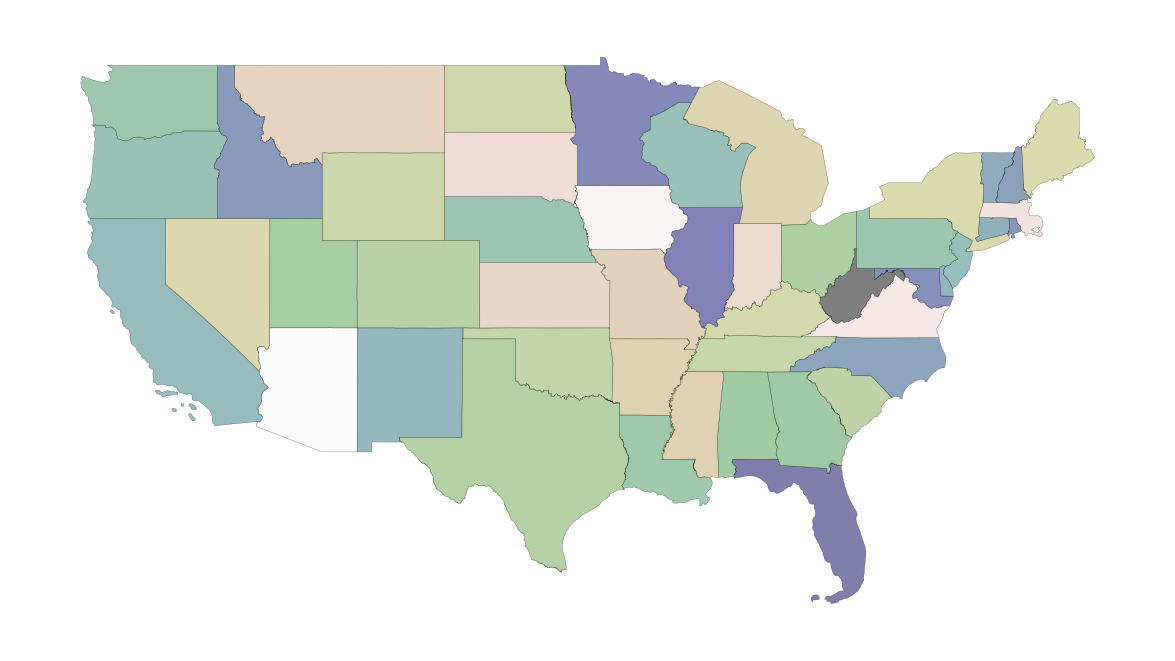

In [16]:
# create a basic continential US figure
f,ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
divider = make_axes_locatable(ax)
ax.set_axis_off()
us49.plot(ax=ax, alpha=0.5, cmap='gist_earth', edgecolor='k', legend=False, linewidth=0.1)
plt.show()

## Scrape NPS data

In [17]:
# url to scrape information from
nps = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park={}'

In [18]:
# create empty list to store park data
#parks_data = []

# temporary parks list for testing
test_park = ['ACAD']

In [19]:
for park in test_park:
    
    # url to monthly data for each park 
    url = nps.format(park)
    
    # extract HTML text
    page = rq.get(url).text
    print(page)
    
    # convert to BeautifulSoup object
    #soup = BeautifulSoup(page)
    
    # pull <table> tag that match our class name
    #table = soup.find('table', class_ = 'Ae30f20f368af4927806ac09a734045d0170')
    
    # find <tr> tags in our specified table, ignoring the labels row
    #temp_table = table.find_all('tr')
    
    # extract park name from <a> tag
    #xyz = park.find('a').get('xyz')
    
    # append information to full parks list
    #park_data.append(xyz)





<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
    <title>Stats Report Viewer</title>
    <link rel="shortcut icon" type="image/x-icon" href="https://irmafiles.nps.gov/WebContent/Irma/Common/v1_0_0/Images/favicon.ico" />
</head>
<body>

<iframe Height="900px" Width="100%" src="/STATS/MvcReportViewer.aspx?_id=0b5e7ea1-305a-402e-97d6-c98bf2f5e391&amp;_m=Remote&amp;_r=%2fNPS.Stats.Reports%2fPark+Specific+Reports%2fRecreation+Visitors+By+Month+(1979+-+Last+Calendar+Year)&amp;_15=True&amp;_16=True&amp;_18=True&amp;_19=True&amp;_34=False&amp;_35=False&amp;_39=880px&amp;Park=ACAD" style="border: none"></iframe></body>
</html>


There seems to be an issue with extracting the HTML text from the webpage. Maybe that's due to javascript? Unclear. There is another popular web-scraping tool called [Selenium](https://oxylabs.io/blog/selenium-web-scraping) that is suppose to work with javascript. I'll try that out next.<br><br>***To be continued***